# GPU and CPU comparison for my RL use

As I start to use my GPU, I would like to understand how it is going to affect my training performance and when I should avoid to use it.

## Initialization of an agent

Let's start with the initialization of the agent. I expect to see worse results for GPU initialization sinc Benoit explained me that for init. The tensor are first initialized in CPU and then in GPU.

### Library imports and default variables 

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir("..")
from perfo_tester import *

In [69]:
state_dim = 100
memory_size = 128
n_hidden_layers = 1
nn_size = 50

Here, I will make the orders of magnitude of the number of parameters vary.

In [35]:

nn_sizes = [10, 100, 1000, 10000, 100000]
cpu_times = []
gpu_times = []
for nn_size in nn_sizes:
    params = make_perfo_params(state_dim, memory_size, n_hidden_layers, nn_size)
    gpu_times += [np.array([get_agent_init_stat(params, "gpu") for i in range(10)]).mean()]
    cpu_times += [np.array([get_agent_init_stat(params, "cpu") for i in range(10)]).mean()]

Let's see how the initialization times compare!

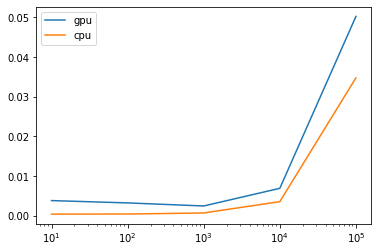

In [39]:
plt.xscale("log")
plt.plot(nn_sizes, gpu_times,label="gpu")
plt.plot(nn_sizes, cpu_times, label="cpu")
plt.legend()

I can indeed see that it is slower on GPU, but it's not clear how much.

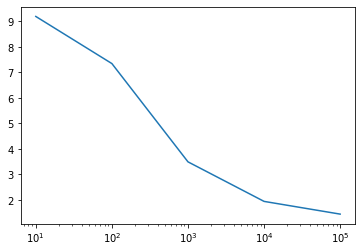

In [38]:
plt.xscale("log")
plt.plot(nn_sizes, np.array(gpu_times) / np.array(cpu_times))

Ok, so it is at worse 10 times slower with a GPU (a single layer of 10 neurons).
And then it gets closer to the same speed as we increse the number of parameters in the NN.
I think that this part is not so important as the initialization of the agent is a negligible part of the training process overall. But it is still good to have the validation that the initialization of the agent is indeed slower with a GPU, particularly when the number of parameters is low.

## A single forward pass and backpropagation

For a first test, let's make the parameters vary the same way as before.

In [70]:

nn_sizes = [10, 100, 1000, 10000, 100000]
gpu_times = []
cpu_times = []
for nn_size in nn_sizes:
    params = make_perfo_params(state_dim, memory_size, n_hidden_layers, nn_size)
    gpu_times += [np.array([get_agent_exec_stat(params, "gpu") for i in range(10)]).mean()]
    cpu_times += [np.array([get_agent_exec_stat(params, "cpu") for i in range(10)]).mean()]

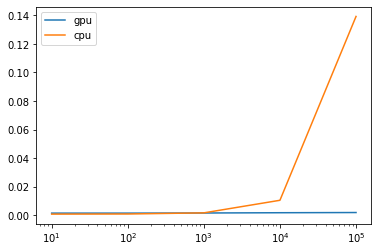

In [71]:
plt.xscale("log")
plt.plot(nn_sizes, gpu_times,label="gpu")
plt.plot(nn_sizes, cpu_times, label="cpu")
plt.legend()

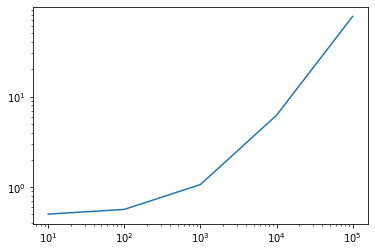

In [72]:
plt.xscale("log")
plt.yscale("log")
plt.plot(nn_sizes, np.array(cpu_times) / np.array(gpu_times))

Interesting!

Here, we see that the performance for the use of a GPU is worse than for a CPU when the number of parameters in a single layer is below 1000 parameters. It's never worse than 2 times slower.

But it seems to grow exponentially as we scale up the layer! Up until 100 times better for 10000 parameters.

Now that we know that for a layer of 1000 neurons, we get approximately the same performance, let's make the number of layers vary.

In [64]:
n_hidden_layerss = [1, 3, 5, 10, 20, 30, 40, 50, 75, 100, 125, 150, 200]
nn_size = 1000
gpu_times = []
cpu_times = []
for n_hidden_layers in n_hidden_layerss:
    print(n_hidden_layers)
    params = make_perfo_params(state_dim, memory_size, n_hidden_layers, nn_size)
    gpu_times += [np.array([get_agent_exec_stat(params, "gpu") for i in range(10)]).mean()]
    cpu_times += [np.array([get_agent_exec_stat(params, "cpu") for i in range(10)]).mean()]

1
3
5
10
20
30
40
50
75
100
125
150
200


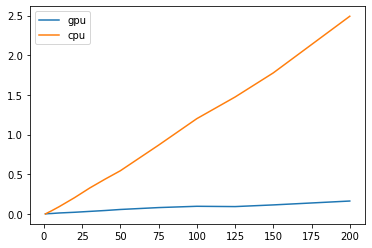

In [65]:
#plt.xscale("log")
plt.plot(n_hidden_layerss, gpu_times,label="gpu")
plt.plot(n_hidden_layerss, cpu_times, label="cpu")
plt.legend()

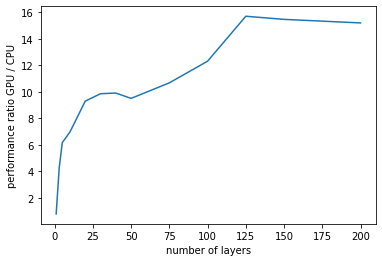

In [67]:
plt.xlabel("number of layers")
plt.ylabel("performance ratio GPU / CPU")
plt.plot(n_hidden_layerss, np.array(cpu_times) / np.array(gpu_times))

Clearly, here we see that the more I add layers, the better the performance of the GPU is.
If the performance of a single layer is approximately similar for a single layer, the GPU is up to 16 times more performant when there are 50 layers.

I didn't expect this result since I thought that GPU operations were better only for parallelization.

The fact that the curve goes down after 50 layers is concerning. Why would it happen?

Anyway, as we increase further, it goes up again and stabilizes to a 16 fold performance in favor of the GPU.